In [ ]:
"""Shared inference utilities extracted from the original notebook.

This module centralizes the ML, CV, and optional RL inference steps that were
previously defined inside ``app/inference_pipeline.ipynb`` so that they can be
imported and reused without executing notebook cells.
"""
from __future__ import annotations

import json
import os
from datetime import timedelta
from functools import lru_cache
from typing import Any, Dict, Optional, Tuple

import numpy as np
import pandas as pd
import pytz
from dotenv import load_dotenv
from tinkoff.invest import CandleInterval, Client

try:  # ML
    import xgboost as xgb
except ImportError:  # pragma: no cover - optional dependency
    xgb = None  # type: ignore

try:  # CV
    import torch
    from torch import nn
    from torchvision import transforms
except ImportError:  # pragma: no cover - optional dependency
    torch = None  # type: ignore
    nn = None  # type: ignore
    transforms = None  # type: ignore

try:  # CV backbone
    import timm
except ImportError:  # pragma: no cover - optional dependency
    timm = None  # type: ignore

try:  # Candle rendering
    import mplfinance as mpf
    import matplotlib.pyplot as plt
except ImportError:  # pragma: no cover - optional dependency
    mpf = None  # type: ignore
    plt = None  # type: ignore

from RL import build_feature_frame
from RL.agent import RLAgent
from RL.env import PortfolioState

# === New ML model: SSM (best_ssm_model.pth) ===
import os
import numpy as np
import pandas as pd
import torch

from app.trained_models.ssm_model_for_new_data import predict_new_data as ssm_predict_new_data  # из прикреплённого файла
# best_ssm_model.pth должен лежать рядом с ноутбуком или по указанному пути

from torchvision import models as tv_models



In [2]:
load_dotenv()

DEFAULT_TOKEN = os.getenv("TINKOFF_TOKEN")
DEFAULT_TZ = pytz.timezone("Europe/Moscow")
DEFAULT_TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN

SSM_MODEL_PATH = "best_ssm_model.pth"
SSM_SEQ_LEN = 60  # как в конфиге модели

In [3]:
def fetch_tinkoff_candles(
    token: str,
    ticker: str,
    days: int = 1,
    interval: CandleInterval = DEFAULT_TIMEFRAME,
    tz: pytz.BaseTzInfo = DEFAULT_TZ,
) -> pd.DataFrame:
    """Download OHLCV candles from the Tinkoff Invest API."""

    if not token:
        raise RuntimeError("TINKOFF_TOKEN is required to fetch candles")

    from tinkoff.invest.services import InstrumentsService  # lazy import
    from tinkoff.invest.utils import now

    with Client(token) as client:
        instruments: InstrumentsService = client.instruments
        shares = instruments.shares().instruments
        figi: Optional[str] = None
        for share in shares:
            if share.ticker.upper() == ticker.upper():
                figi = share.figi
                break
        if not figi:
            raise RuntimeError(f"FIGI for {ticker} not found")

        end = now()
        start = end - timedelta(days=days)
        candles = client.get_all_candles(figi=figi, from_=start, to=end, interval=interval)

        data = [
            {
                "time": candle.time.astimezone(tz),
                "open": candle.open.units + candle.open.nano / 1e9,
                "high": candle.high.units + candle.high.nano / 1e9,
                "low": candle.low.units + candle.low.nano / 1e9,
                "close": candle.close.units + candle.close.nano / 1e9,
                "volume": candle.volume,
            }
            for candle in candles
        ]

    return pd.DataFrame(data)


In [4]:
def compute_atr_wilder(df, n=14):
    """True Range + Wilder's ATR, если нет atr_14 в CSV."""
    high = df['high'].astype(float)
    low  = df['low'].astype(float)
    close= df['close'].astype(float)
    prev_close = close.shift(1)

    tr1 = (high - low).abs()
    tr2 = (high - prev_close).abs()
    tr3 = (low  - prev_close).abs()
    tr  = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/n, adjust=False).mean()
    return atr

def fit_hmm_regimes(returns, n_states=2):
    X = returns.dropna().values.reshape(-1,1)
    if len(X) < 200:  # минимально, чтобы стабильно
        return None, None
    hmm = GaussianHMM(n_components=n_states, covariance_type='full',
                      n_iter=200, random_state=42)
    hmm.fit(X)
    hidden = pd.Series(hmm.predict(X), index=returns.dropna().index)
    return hmm, hidden.reindex(returns.index)

def garch_sigma(returns):
    # Еженаборная оценка σ_t через (E)GARCH: используем простой GARCH(1,1)
    r = (returns.dropna()*100).astype(float)  # проценты
    if len(r) < 300:
        return returns.abs().rolling(20).std().reindex(returns.index)
    am = arch_model(r, p=1, q=1, mean='Constant', vol='GARCH', dist='normal')
    res = am.fit(disp="off")
    cond_vol = res.conditional_volatility / 100.0  # обратно в доли
    return cond_vol.reindex(returns.index)

def arima_sign(returns):
    # Одношаговый ARIMA sanity-check (легкий)
    y = returns.dropna()
    if len(y) < 100:
        return pd.Series(index=returns.index, dtype=float)
    model = ARIMA(y, order=(1,0,1))
    res = model.fit()
    fc = res.forecast(1)
    sgn = np.sign(fc.iloc[0])
    return pd.Series(sgn, index=returns.index).ffill()

def mc_hit_probs(close_series, mu, sigma, H, n_paths=2000, dt=1):
    # Упрощенный GBM для hit-prob: вернём массив максимумов/минимумов за H шагов
    S0 = close_series.iloc[-1]
    z = np.random.normal(size=(n_paths, H))
    steps = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    paths = S0 * np.exp(np.cumsum(steps, axis=1))
    max_arr = paths.max(axis=1)
    min_arr = paths.min(axis=1)
    return max_arr, min_arr

def kelly_lite(prob_up, R=1.0, f_max=0.1):
    p = np.clip(prob_up, 1e-6, 1-1e-6)
    f = (p*R - (1-p))/R
    return float(np.clip(f, 0.0, f_max))

def overlays_postprocess(df):
    """
    Пост-обработка сигналов с жёстким консенсусом по лейблам.
    Сигнал строится ТОЛЬКО если:
      - есть оба лейбла: ml_label и cv_label
      - лейблы совпадают и это 'up' или 'down'
    Иначе по строке оставляем NaN-вероятности и пропускаем её при генерации сигналов.

    Поля входного df:
      - обязательно: time, close, high, low
      - желательно: ml_label, ml_proba, cv_label, cv_proba
      - опционально (учтутся только при наличии консенсуса): ml_proba_up/down, cv_proba_up/down
      - опционально: atr_14 (иначе считаем), предикторы для HMM/GARCH/ARIMA

    На выход добавляет: signal, tp_price, sl_price, size, regime, sigma_t, arima_sign, consensus_dir, proba_up, proba_down.
    """
    import numpy as np
    import pandas as pd

    # ---------------- helpers ----------------
    def _safe_float(x):
        try:
            v = float(x)
            return v if np.isfinite(v) else None
        except Exception:
            return None

    def _map_probs(label, p):
        """
        Превращает одну пару (label, p) -> (p_up, p_down).
        Остаток (1-p) делим поровну между двумя оставшимися классами.
        Возвращает None при любой проблеме.
        """
        try:
            if label is None:
                return None
            p = float(p)
            if not np.isfinite(p):
                return None
            p = float(np.clip(p, 0.0, 1.0))
            rem = max(0.0, 1.0 - p)
            lab = str(label).lower()
            if lab == 'up':
                return p, rem / 2.0
            elif lab == 'down':
                return rem / 2.0, p
            else:
                # 'flat' или прочее — равномерно между up/down
                return rem / 2.0, rem / 2.0
        except Exception:
            return None

    def _consensus_label(row):
        """
        Жёсткий консенсус: оба лейбла существуют, равны, и это 'up' или 'down'.
        Иначе None.
        """
        try:
            a = str(row.get('ml_label', '')).lower()
            b = str(row.get('cv_label', '')).lower()
            if a in {'up', 'down'} and a == b:
                return a
        except Exception:
            pass
        return None

    # ---------------- подготовка ----------------
    df = df.sort_values('time').reset_index(drop=True).copy()
    assert {'close', 'high', 'low'}.issubset(df.columns), "Нужны колонки close/high/low"

    # ATR при необходимости
    if 'atr_14' not in df.columns:
        df['atr_14'] = compute_atr_wilder(df, n=14)

    # Лог-доходности
    df['logret'] = np.log(df['close']).diff()

    # HMM режимы
    try:
        hmm, regimes = fit_hmm_regimes(df['logret'])
        df['regime'] = regimes
    except Exception:
        df['regime'] = np.nan

    # GARCH волатильность
    try:
        df['sigma_t'] = garch_sigma(df['logret'])
        vol_cut = df['sigma_t'].quantile(VOL_PCTL_ABS)
    except Exception:
        df['sigma_t'] = df['logret'].rolling(20).std()
        # запасной квантиль, если глобальная константа не задана
        vol_cut = df['sigma_t'].quantile(0.95)

    # Лёгкий ARIMA sign
    try:
        df['arima_sign'] = arima_sign(df['logret'])
    except Exception:
        df['arima_sign'] = np.nan

    # ---------------- консенсус + сбор вероятностей ----------------
    # 1) метка консенсуса
    df['consensus_dir'] = df.apply(_consensus_label, axis=1)

    # 2) строим proba_up/proba_down только там, где есть консенсус
    proba_up_vals, proba_down_vals = [], []
    for row in df.itertuples(index=False):
        # если нет консенсуса — строго NaN
        if getattr(row, 'consensus_dir', None) is None:
            proba_up_vals.append(np.nan)
            proba_down_vals.append(np.nan)
            continue

        ups, downs = [], []

        # из пар (label, proba)
        try:
            t = _map_probs(getattr(row, 'ml_label', None), getattr(row, 'ml_proba', None))
            if t is not None:
                ups.append(t[0]); downs.append(t[1])
        except Exception:
            pass

        try:
            t = _map_probs(getattr(row, 'cv_label', None), getattr(row, 'cv_proba', None))
            if t is not None:
                ups.append(t[0]); downs.append(t[1])
        except Exception:
            pass

        # прямые up/down поля учитываем ТОЛЬКО при наличии консенсуса
        try:
            u = _safe_float(getattr(row, 'ml_proba_up', None))
            d = _safe_float(getattr(row, 'ml_proba_down', None))
            if u is not None and d is not None:
                ups.append(u); downs.append(d)
        except Exception:
            pass

        try:
            u = _safe_float(getattr(row, 'cv_proba_up', None))
            d = _safe_float(getattr(row, 'cv_proba_down', None))
            if u is not None and d is not None:
                ups.append(u); downs.append(d)
        except Exception:
            pass

        if len(ups) > 0:
            proba_up_vals.append(float(np.mean(ups)))
            proba_down_vals.append(float(np.mean(downs)))
        else:
            # даже при консенсусе, если значений нет или они невалидны — NaN
            proba_up_vals.append(np.nan)
            proba_down_vals.append(np.nan)

    df['proba_up'] = pd.Series(proba_up_vals, index=df.index)
    df['proba_down'] = pd.Series(proba_down_vals, index=df.index)

    # ---------------- основной цикл сигналов ----------------
    out = []
    for i, row in df.iterrows():
        # Разогрев и NaN logret
        if i < 50 or pd.isna(row['logret']):
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Фильтр по волатильности
        if not pd.isna(row['sigma_t']) and row['sigma_t'] >= vol_cut:
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Жёстко требуем консенсус + валидные proba
        if pd.isna(row['consensus_dir']) or pd.isna(row['proba_up']) or pd.isna(row['proba_down']):
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # Порог вероятности с поправкой на режим
        thr = BASE_THR
        try:
            if not pd.isna(row['regime']) and int(row['regime']) == 1:
                thr = BASE_THR + 0.05
        except Exception:
            pass

        # Направление фиксируем по консенсусу
        direction = 'long' if row['consensus_dir'] == 'up' else 'short'
        long_cond = (direction == 'long') and (row['proba_up'] >= thr)
        short_cond = (direction == 'short') and (row['proba_down'] >= thr)

        if not long_cond and not short_cond:
            out.append((0, float('nan'), float('nan'), 0.0))
            continue

        # ARIMA sanity-check: отфильтровать «почти на пороге» против знака
        if direction == 'long':
            if (not pd.isna(row['arima_sign']) and row['arima_sign'] < 0 and
                row['proba_up'] < (thr + 0.05)):
                out.append((0, float('nan'), float('nan'), 0.0))
                continue
        else:  # short
            if (not pd.isna(row['arima_sign']) and row['arima_sign'] > 0 and
                row['proba_down'] < (thr + 0.05)):
                out.append((0, float('nan'), float('nan'), 0.0))
                continue

        # ATR и sigma
        atr = row['atr_14']
        sigma = row['sigma_t'] if not pd.isna(row['sigma_t']) else df['logret'].rolling(20).std().iloc[i]
        step = max(TP_ATR_K * atr, 2.0 * sigma * row['close'])

        # Базовые TP/SL
        if direction == 'long':
            base_tp = row['close'] + step
            base_sl = row['close'] - step * (SL_ATR_K / TP_ATR_K)
        else:
            base_tp = row['close'] - step
            base_sl = row['close'] + step * (SL_ATR_K / TP_ATR_K)

        # Monte-Carlo фильтр hit-prob
        try:
            if not pd.isna(sigma) and sigma > 0:
                mu_loc = df['logret'].iloc[max(0, i-50):i].mean()
                max_arr, min_arr = mc_hit_probs(df['close'].iloc[:i+1],
                                                mu=mu_loc, sigma=sigma, H=H, n_paths=1500)
                if direction == 'long':
                    p_hit_tp = (max_arr >= base_tp).mean()
                    p_hit_sl = (min_arr <= base_sl).mean()
                else:
                    p_hit_tp = (min_arr <= base_tp).mean()
                    p_hit_sl = (max_arr >= base_sl).mean()
                if p_hit_tp < p_hit_sl + MARGIN_HIT:
                    out.append((0, float('nan'), float('nan'), 0.0))
                    continue
        except Exception:
            # если симуляция упала — не фильтруем
            pass

        # Сайзинг позиции: Келли + таргет-воль
        R = abs((base_tp - row['close']) / max(abs(row['close'] - base_sl), 1e-9))
        prob = row['proba_up'] if direction == 'long' else row['proba_down']
        f_kelly = kelly_lite(prob, R=R, f_max=F_MAX)
        size_vol = TARGET_VOL / max(sigma, 1e-6) if not pd.isna(sigma) else F_MAX
        size = float(np.clip(min(f_kelly, size_vol), 0.0, F_MAX))

        signal = 1 if direction == 'long' else -1
        out.append((signal, base_tp, base_sl, size))

    # ---------------- выходные столбцы ----------------
    df['signal']   = [o[0] for o in out]
    df['tp_price'] = [o[1] for o in out]
    df['sl_price'] = [o[2] for o in out]
    df['size']     = [o[3] for o in out]

    return df


In [ ]:

def compute_ssm_base_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Готовим входные фичи для SSM-модели.
    Формулы согласованы с README к модели: SMA/EMA, RSI, Bollinger, momentum, log_ret, ATR.
    Ожидается, что df содержит как минимум: time, open, high, low, close, volume.
    """
    df = df.sort_values("time").reset_index(drop=True).copy()

    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)

    # Простые и экспоненциальные средние
    df["sma_5"] = df["close"].rolling(5).mean()
    df["sma_10"] = df["close"].rolling(10).mean()
    df["ema_10"] = df["close"].ewm(span=10, adjust=False).mean()
    df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()

    # Отношение цены к средней
    df["sma_ratio"] = df["close"] / df["sma_10"]

    # RSI(14)
    delta = df["close"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    window_rsi = 14
    avg_gain = gain.rolling(window_rsi).mean()
    avg_loss = loss.rolling(window_rsi).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df["rsi"] = 100 - (100 / (1 + rs))

    # полосы Боллинджера (20)
    window_bb = 20
    df["boll_mid"] = df["close"].rolling(window_bb).mean()
    df["boll_std"] = df["close"].rolling(window_bb).std()
    df["boll_up"] = df["boll_mid"] + 2 * df["boll_std"]
    df["boll_low"] = df["boll_mid"] - 2 * df["boll_std"]
    df["boll_pos"] = (df["close"] - df["boll_mid"]) / df["boll_std"].replace(0, np.nan)

    # Моментумы
    df["momentum_5"] = df["close"] / df["close"].shift(5) - 1.0
    df["momentum_10"] = df["close"] / df["close"].shift(10) - 1.0

    # Лог-доходность и ATR (можно использовать уже существующую функцию)
    df["log_ret"] = np.log(df["close"] / df["close"].shift(1))
    df["atr"] = compute_atr_wilder(df, n=14)  # функция у тебя уже есть выше

    return df


def predict_ml_ssm(
    df_candles: pd.DataFrame,
    model_path: str = SSM_MODEL_PATH,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """
    Запуск новой SSM-модели на свечном DataFrame df_candles.

    Возвращает словарь того же формата, что и старый predict_ml:
        {
          "indices": [int...],   # 0=down, 1=flat, 2=up
          "labels":  [str...],   # "down"/"flat"/"up"
          "proba":   np.ndarray  # (N, 3) в порядке [P(down), P(flat), P(up)]
        }

    Может вернуть пустые списки/массивы, если истории ещё недостаточно.
    """
    # 1) посчитаем фичи для SSM
    df_feat = compute_ssm_base_features(df_candles.copy())

    # SSM-скрипт ожидает колонку label, от которой строит label_encoded.
    # На живых данных лейблов нет — ставим заглушку.
    if "label" not in df_feat.columns:
        df_feat["label"] = "flat"

    # 2) сохраним временный CSV и используем готовую функцию predict_new_data
    tmp_path = "_tmp_ssm_input.csv"
    df_feat.to_csv(tmp_path, index=False)

    res_df = ssm_predict_new_data(model_path, tmp_path, sequence_length=SSM_SEQ_LEN)

    # --- критично: нет ни одной валидной последовательности ---
    if res_df is None or len(res_df) == 0:
        result: Dict[str, Any] = {
            "indices": [],
            "labels": [],
        }
        if return_proba:
            result["proba"] = np.zeros((0, 3), dtype=float)
        return result

    # 3) собираем результат в формате [down, flat, up]
    probs = res_df[["prob_down", "prob_flat", "prob_up"]].to_numpy()

    label_to_idx = {"down": 0, "flat": 1, "up": 2}
    labels = res_df["predicted_label"].tolist()
    indices = [label_to_idx.get(lbl, 1) for lbl in labels]  # default -> flat

    result: Dict[str, Any] = {"indices": indices, "labels": labels}
    if return_proba:
        result["proba"] = probs

    # опционально можно удалить временный файл
    try:
        os.remove(tmp_path)
    except OSError:
        pass

    return result


In [6]:
from torchvision import models as tv_models

def add_cv_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute EMA and Bollinger band overlays for candlestick rendering."""

    df = df.copy()
    df["ema_10"] = df["close"].ewm(span=10).mean()
    df["ema_20"] = df["close"].ewm(span=20).mean()
    mid = df["close"].rolling(20).mean()
    std = df["close"].rolling(20).std()
    df["boll_up"] = mid + 2 * std
    df["boll_low"] = mid - 2 * std
    return df


def render_candle_image(
    sub_df: pd.DataFrame,
    img_size: tuple = (8, 4),
    dpi: int = 100,
    use_jpg: bool = True,
    style: Optional[Any] = None,
) -> np.ndarray:
    """Render a single candlestick window into a NumPy RGB image."""

    if mpf is None or plt is None:
        raise ImportError(
            "mplfinance and matplotlib must be installed to render candle images; install them via `pip install mplfinance matplotlib`"
        )

    if style is None:
        mc = mpf.make_marketcolors(up="lime", down="red", edge="white", wick="white", volume="gray")
        style = mpf.make_mpf_style(
            base_mpf_style="nightclouds",
            facecolor="black",
            edgecolor="white",
            marketcolors=mc,
            rc={"axes.labelcolor": "white", "axes.edgecolor": "white"},
        )

    fig, axes = mpf.plot(
        sub_df,
        type="candle",
        style=style,
        volume=True,
        figsize=img_size,
        tight_layout=True,
        show_nontrading=True,
        returnfig=True,
    )
    for ax in axes:
        ax.set_axis_off()
        ax.grid(False)
    if "ema_10" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_10"], color="deepskyblue", linewidth=1)
    if "ema_20" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_20"], color="orange", linewidth=1)
    if {"boll_up", "boll_low"}.issubset(sub_df.columns):
        axes[0].plot(sub_df.index, sub_df["boll_up"], color="gray", linestyle="--", linewidth=0.8)
        axes[0].plot(sub_df.index, sub_df["boll_low"], color="gray", linestyle="--", linewidth=0.8)

    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(buf, dtype=np.uint8).reshape((h, w, 4))[..., :3]
    plt.close(fig)
    return img


def prepare_cv_tensor(img: np.ndarray):
    """Convert an RGB image array into a Torch tensor for the new ResNet50 CV model."""

    if torch is None or transforms is None:
        raise ImportError("torch and torchvision must be installed to prepare image tensors")

    # Та же предобработка, что в обучении: Resize(512,512) + ToTensor()
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
        ]
    )
    return transform(img).unsqueeze(0)


def create_cv_model_resnet50(num_classes: int, device: Optional[str] = None):
    """
    ResNet50 + кастомная голова, как в cv_model.ipynb.
    Используется только для инференса: веса потом перезапишутся из чекпоинта.
    """
    if torch is None or nn is None:
        raise ImportError("torch must be installed to create the CV model")

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    model = tv_models.resnet50(weights=tv_models.ResNet50_Weights.IMAGENET1K_V2)
    in_feat = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes),
    )

    model.to(device)
    model.eval()
    return model


def load_cv_model(meta_path: str, model_path: str, device: Optional[str] = None):
    """
    Загрузка новой CV модели (ResNet50), натренированной в cv_model.ipynb.

    meta_path  — путь к label_map.json (или к json, внутри которого есть ключ 'label_map')
    model_path — путь к best_cv_model.pth
    """
    if torch is None or nn is None:
        raise ImportError("torch must be installed to load the CV model")

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # meta может быть либо {"label_map": {...}}, либо сразу {...}
    with open(meta_path, "r") as f:
        meta_json = json.load(f)
    label_map = meta_json.get("label_map", meta_json)  # типичный случай: {"up": 2, "down": 0, ...}
    num_classes = len(label_map)

    model = create_cv_model_resnet50(num_classes=num_classes, device=device)

    checkpoint = torch.load(model_path, map_location=device)
    # В твоём чекпоинте: {'epoch', 'model_state_dict', 'optimizer_state_dict', 'val_acc', 'train_acc'}
    state_dict = (
        checkpoint["model_state_dict"]
        if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint
        else checkpoint
    )
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model


def predict_cv(
    model: "nn.Module",
    img_tensor: "torch.Tensor",
    meta_path: str,
    device: Optional[str] = None,
    return_proba: bool = True,
) -> Dict[str, Any]:
    """
    Инференс новой CV-модели.

    Возвращает:
      - 'indices': список индексов классов
      - 'labels':  список строковых лейблов ('up'/'down'/'flat')
      - 'proba':   np.ndarray (N, C) с вероятностями (если return_proba=True)
    """
    if torch is None:
        raise ImportError("torch must be installed to perform CV inference")

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).cpu().numpy()
        probs_np = probs.cpu().numpy()

    # Загружаем label_map и строим idx -> label
    with open(meta_path, "r") as f:
        meta_json = json.load(f)
    label_map = meta_json.get("label_map", meta_json)
    idx_to_label = {idx: lab for lab, idx in label_map.items()}

    labels = [idx_to_label.get(int(i), str(i)) for i in pred_idx]

    result: Dict[str, Any] = {"indices": pred_idx.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs_np
    return result


In [ ]:
@lru_cache(maxsize=1)
def load_rl_agent(model_path: str, window_size: int, initial_balance: float) -> RLAgent:
    """Load and cache the PPO-based RL agent for inference."""

    return RLAgent(model_path=model_path, window_size=window_size, initial_balance=initial_balance)


def prepare_rl_state(
    df: pd.DataFrame,
    window_size: int,
    initial_balance: float,
    position: int = 0,
    equity: Optional[float] = None,
) -> Tuple[pd.DataFrame, PortfolioState]:
    """Compute RL feature frame and latest portfolio state for action selection."""

    features = build_feature_frame(df)
    if features.empty:
        raise ValueError("Cannot build RL features from an empty DataFrame")

    pointer = len(features) - 1
    state = PortfolioState(
        pointer=pointer,
        position=position,
        equity=equity if equity is not None else initial_balance,
    )
    return features, state


In [8]:
def run_full_inference(
    ticker: str = "SBER",
    tf: CandleInterval = DEFAULT_TIMEFRAME,
    days: int = 1,
    lookback: int = 60,
    ml_model_path: str = "xgb_sber.model",
    cv_model_path: str = "best_model.pth",
    meta_path: str = "meta.json",
    token: Optional[str] = DEFAULT_TOKEN,
    tz_name: str = "Europe/Amsterdam",
    use_rl: bool = False,
    rl_model_path: str = "models/rl/checkpoints/ppo_trading_agent.zip",
    rl_window: int = 32,
    initial_balance: float = 100_000.0,
    portfolio_position: int = 0,
    portfolio_equity: Optional[float] = None,
) -> Dict[str, Any]:
    """Run ML, CV, and optional RL models on the most recent candle data."""

    tz = pytz.timezone(tz_name)
    df_candles = fetch_tinkoff_candles(token or "", ticker, days=days, interval=tf, tz=tz)
    if df_candles.empty:
        raise RuntimeError("No candle data available for inference")
    df_candles = df_candles.sort_values("time").reset_index(drop=True)

    ml_model = load_xgb_model(ml_model_path)
    feats_df = compute_ml_features(df_candles).dropna()
    ml_result = predict_ml(ml_model, feats_df, return_proba=True)

    df_feat = add_cv_features(df_candles)
    if len(df_feat) < lookback:
        raise ValueError(
            f"Not enough candles ({len(df_feat)}) for lookback={lookback}. Increase history length or decrease lookback."
        )
    sub = df_feat.iloc[-lookback:].copy()
    sub["time"] = pd.to_datetime(sub["time"])
    sub = sub.set_index("time")
    img = render_candle_image(sub, img_size=(8, 4), dpi=100, use_jpg=True)
    img_tensor = prepare_cv_tensor(img)
    cv_model = load_cv_model(meta_path, cv_model_path)
    cv_result = predict_cv(cv_model, img_tensor, meta_path, return_proba=True)

    rl_state = None
    rl_features = None
    if use_rl:
        agent = load_rl_agent(rl_model_path, rl_window, initial_balance)
        rl_features, rl_state = prepare_rl_state(
            df_candles,
            window_size=rl_window,
            initial_balance=initial_balance,
            position=portfolio_position,
            equity=portfolio_equity if portfolio_equity is not None else initial_balance,
        )
        raw_pos, label, size_frac = agent.get_action(rl_features, rl_state)

    result: Dict[str, Any] = {"ml_preds": ml_result, "cv_preds": cv_result, "df_candles": df_candles}
    if use_rl:
        result.update(
            {
                "rl_action": raw_pos,
                "rl_action_label": label,
                "rl_action_size": size_frac,
                "rl_portfolio_state": rl_state,
                "rl_features": rl_features.tail(rl_window) if rl_features is not None else None,
            }
        )

    return result


In [ ]:
# Недельный бэктест пайплайна ML + CV + RL + риск-менеджмент

import numpy as np
import pandas as pd
from datetime import datetime

# ---------------- параметры ----------------
ticker = "SBER"

start_date = pd.Timestamp("2025-11-21 00:00:00", tz=DEFAULT_TZ)
end_date   = pd.Timestamp("2025-11-28 23:59:59", tz=DEFAULT_TZ)

lookback_cv = 60          # окно свечей для CV-картинки
rl_window   = 32          # окно для RL
initial_balance = 100_000.0

ml_model_path = "best_ssm_model.pth"
# cv_model_path = "best_model.pth"
# meta_path     = "meta.json"
cv_model_path="best_cv_model.pth"  # новый CV чекпоинт
meta_path="label_map.json"
rl_model_path = "../models/rl/checkpoints/ppo_trading_agent.zip"

# риск-менеджмент (можно подстроить под overlays_postprocess)
TP_ATR_K = 5.0
SL_ATR_K = 2.0

# ---------------- загрузка моделей ----------------
# ml_model = load_xgb_model(ml_model_path)
cv_model = load_cv_model(meta_path, cv_model_path)
rl_agent = load_rl_agent(rl_model_path, rl_window, initial_balance)

# ---------------- загрузка свечей и ATR ----------------
raw_df = fetch_tinkoff_candles(
    token=DEFAULT_TOKEN or "",
    ticker=ticker,
    days=10,                       # достаточно, чтобы покрыть нужную неделю
    interval=DEFAULT_TIMEFRAME,
    tz=DEFAULT_TZ,
)
raw_df = raw_df.sort_values("time").reset_index(drop=True)

df_week = raw_df[
    (raw_df["time"] >= start_date) & (raw_df["time"] <= end_date)
].reset_index(drop=True)

if df_week.empty:
    raise RuntimeError("Нет свечей в указанном диапазоне дат")

# ATR по Уайлдеру для риск-менеджмента
df_week["atr_14"] = compute_atr_wilder(df_week, n=14)

# ---------------- цикл бэктеста ----------------
balance = initial_balance

open_pos = None  # dict с ключами: direction, entry_price, tp, sl, size_frac, open_time
records = []

for i in range(len(df_week)):
    row = df_week.iloc[i]
    ts = row["time"]
    close_price = float(row["close"])
    high_price = float(row["high"])
    low_price  = float(row["low"])

    # --- 1. Если позиция уже открыта — проверяем TP/SL ---
    if open_pos is not None:
        direction   = open_pos["direction"]       # +1 long, -1 short
        entry_price = open_pos["entry_price"]
        tp_price    = open_pos["tp"]
        sl_price    = open_pos["sl"]
        size_frac   = open_pos["size_frac"]       # доля капитала в сделке

        hit_tp = False
        hit_sl = False
        exit_price = None

        if direction > 0:  # long
            if high_price >= tp_price:
                hit_tp = True
                exit_price = tp_price
            elif low_price <= sl_price:
                hit_sl = True
                exit_price = sl_price
        else:  # short
            if low_price <= tp_price:
                hit_tp = True
                exit_price = tp_price
            elif high_price >= sl_price:
                hit_sl = True
                exit_price = sl_price

        if hit_tp or hit_sl:
            # PnL как доля капитала
            pnl_frac = direction * size_frac * (exit_price - entry_price) / entry_price
            balance *= (1.0 + pnl_frac)

            records.append(
                {
                    "time": ts,
                    "event": "close_tp" if hit_tp else "close_sl",
                    "direction": direction,
                    "entry_price": entry_price,
                    "exit_price": exit_price,
                    "size_frac": size_frac,
                    "balance": balance,
                }
            )
            open_pos = None
        else:
            # позиция жива, закрывать нельзя
            records.append(
                {
                    "time": ts,
                    "event": "hold",
                    "direction": direction,
                    "entry_price": entry_price,
                    "exit_price": None,
                    "size_frac": size_frac,
                    "balance": balance,
                }
            )
            continue  # к открытию новой позиции не переходим

    # --- 2. Если позиции нет — возможно, откроем новую ---
    # Небольшой разогрев, чтобы и ML, и CV, и RL имели историю
    warmup = max(lookback_cv, rl_window, SSM_SEQ_LEN + 20)  # например 80 баров
    if i < warmup:
        records.append(
            {
                "time": ts,
                "event": "warmup",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    hist = df_week.iloc[: i + 1].copy()

    # --- 2.1 ML-прогноз на последней свече ---
    # ml_feats = compute_ml_features(hist).dropna()
    # ml_res = predict_ml(ml_model, ml_feats.tail(1), return_proba=True)
    ml_res = predict_ml_ssm(hist, model_path=ml_model_path, return_proba=True)
    if len(ml_res["labels"]) == 0:
        records.append(
            {
                "time": ts,
                "event": "no_trade_ml_warmup",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    ml_label = ml_res["labels"][-1]                    # 'up' / 'down' / 'flat'
    ml_probs = ml_res["proba"][-1]
    ml_idx   = ml_res["indices"][-1]
    ml_conf  = float(ml_probs[ml_idx])                # вероятность предсказанного класса
    print("ML: label - ", ml_label, "; proba - ", ml_conf)

    # --- 2.2 CV-прогноз по картинке последних свечей ---
    cv_df = add_cv_features(hist)
    sub = cv_df.iloc[-lookback_cv:].copy()
    sub["time"] = pd.to_datetime(sub["time"])
    sub = sub.set_index("time")
    img = render_candle_image(sub, img_size=(8, 4), dpi=100, use_jpg=True)
    img_tensor = prepare_cv_tensor(img)
    cv_res = predict_cv(cv_model, img_tensor, meta_path, return_proba=True)
    cv_label = cv_res["labels"][-1]                   # 'up' / 'down' / 'flat'
    cv_probs = cv_res["proba"][-1]
    cv_idx   = cv_res["indices"][-1]
    cv_conf  = float(cv_probs[cv_idx])
    print("CV: label - ", cv_label, "; proba - ", cv_conf)

    # --- 2.3 Правила открытия позиции (ML+CV консенсус) ---
    # 1) Один из лейблов flat → не торгуем
    if ml_label == "flat" or cv_label == "flat":
        records.append(
            {
                "time": ts,
                "event": "no_trade_flat",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    # 2) Лейблы отличаются → не торгуем
    if ml_label != cv_label:
        records.append(
            {
                "time": ts,
                "event": "no_trade_disagree",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    # 3) У любой модели вероятность < 0.5 → не торгуем
    if ml_conf < 0.8 or cv_conf < 0.8:
        records.append(
            {
                "time": ts,
                "event": "no_trade_low_conf",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    # Консенсусное направление: up → long, down → short
    direction = 1 if ml_label == "up" else -1

    # --- 2.4 RL-экшен: размер позиции ---
    rl_features, rl_state = prepare_rl_state(
        hist,
        window_size=rl_window,
        initial_balance=initial_balance,
        position=0,
        equity=balance,
    )
    raw_pos, rl_label, rl_size = rl_agent.get_action(rl_features, rl_state)
    # rl_size ∈ [0,1], raw_pos ∈ [-1,1]

    if rl_size <= 0.0:
        # RL говорит "по сути flat" → не открываемся
        records.append(
            {
                "time": ts,
                "event": "no_trade_rl_flat",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    rl_direction = 1 if raw_pos > 0 else -1
    if rl_direction != direction:
        records.append(
            {
                "time": ts,
                "event": "no_trade_rl_disagree",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    # по условию: используем 10% доступного баланса * |экшен|
    size_frac = 0.15 * rl_size  # доля капитала в сделке

    # --- 2.5 Риск-менеджмент: TP/SL по ATR ---
    atr = float(df_week.loc[i, "atr_14"])
    if not np.isfinite(atr) or atr <= 0:
        records.append(
            {
                "time": ts,
                "event": "no_trade_no_atr",
                "direction": 0,
                "entry_price": None,
                "exit_price": None,
                "size_frac": 0.0,
                "balance": balance,
            }
        )
        continue

    if direction > 0:  # long
        tp_price = close_price + TP_ATR_K * atr
        sl_price = close_price - SL_ATR_K * atr
    else:              # short
        tp_price = close_price - TP_ATR_K * atr
        sl_price = close_price + SL_ATR_K * atr

    # Открываем позицию, держим до TP/SL
    open_pos = {
        "direction": direction,
        "entry_price": close_price,
        "tp": tp_price,
        "sl": sl_price,
        "size_frac": size_frac,
        "open_time": ts,
    }
    records.append(
        {
            "time": ts,
            "event": "open",
            "direction": direction,
            "entry_price": close_price,
            "exit_price": None,
            "size_frac": size_frac,
            "balance": balance,
        }
    )

# ---------------- результат: лог сделок и equity ----------------
backtest_df = pd.DataFrame(records).sort_values("time").reset_index(drop=True)

print("Начальный баланс:", initial_balance)
print("Финальный баланс:", backtest_df["balance"].iloc[-1])
backtest_df.tail()


ML: label -  up ; proba -  0.9596138000488281
CV: label -  up ; proba -  0.7661554217338562
ML: label -  flat ; proba -  0.791584849357605
CV: label -  up ; proba -  0.7811166644096375
ML: label -  down ; proba -  0.939421534538269
CV: label -  up ; proba -  0.7726905941963196
ML: label -  flat ; proba -  0.6402323246002197
CV: label -  up ; proba -  0.8670384287834167
ML: label -  flat ; proba -  0.8467879295349121
CV: label -  up ; proba -  0.6252762079238892
ML: label -  up ; proba -  0.8384167551994324
CV: label -  up ; proba -  0.6604757905006409
ML: label -  flat ; proba -  0.958092451095581
CV: label -  up ; proba -  0.5621380805969238
ML: label -  flat ; proba -  0.9182787537574768
CV: label -  up ; proba -  0.8647981882095337
ML: label -  flat ; proba -  0.8428967595100403
CV: label -  up ; proba -  0.8273847103118896
ML: label -  flat ; proba -  0.7663676142692566
CV: label -  up ; proba -  0.6207007765769958
ML: label -  flat ; proba -  0.9850522875785828
CV: label -  up ; p

,time,event,direction,entry_price,exit_price,size_frac,balance
1768,2025-11-28 23:25:00+03:00,hold,1,304.18,NaN,0.1,100020.588079
1769,2025-11-28 23:30:00+03:00,hold,1,304.18,NaN,0.1,100020.588079
1770,2025-11-28 23:35:00+03:00,hold,1,304.18,NaN,0.1,100020.588079
1771,2025-11-28 23:40:00+03:00,hold,1,304.18,NaN,0.1,100020.588079
1772,2025-11-28 23:45:00+03:00,hold,1,304.18,NaN,0.1,100020.588079


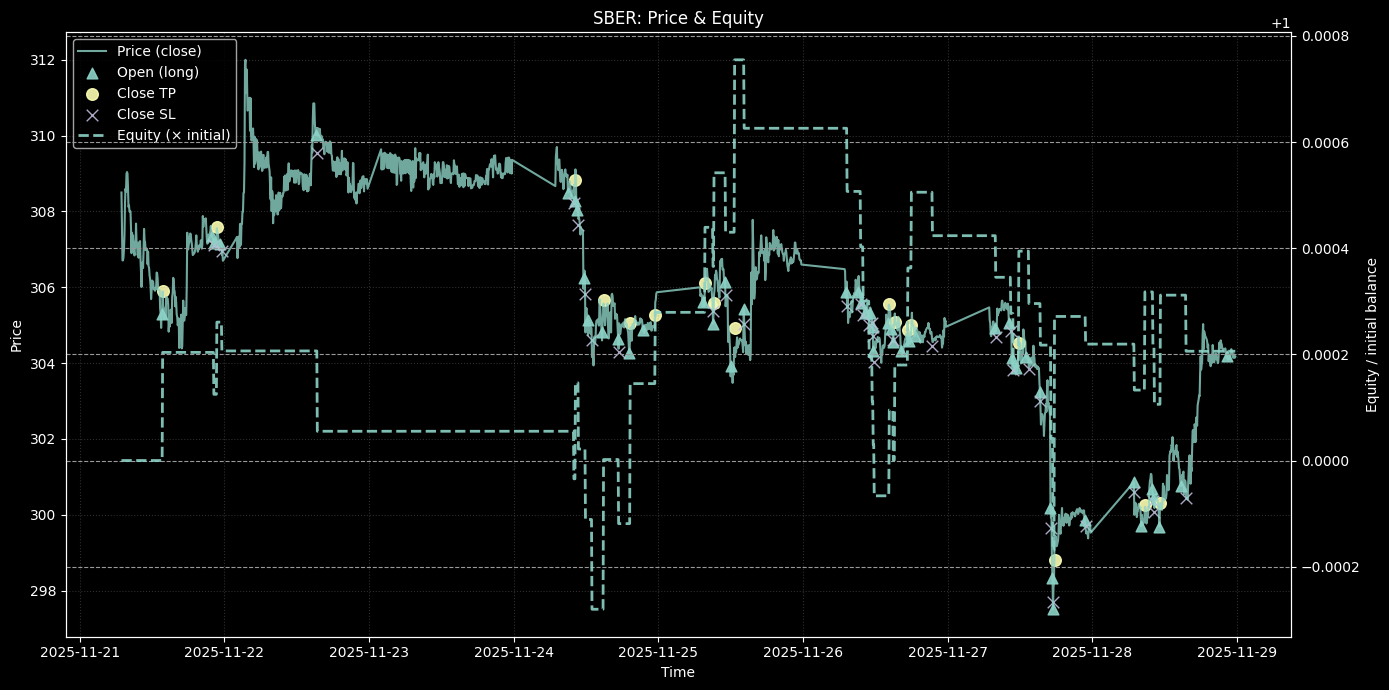

In [14]:
# График цены + equity + точки входа/выхода

import matplotlib.pyplot as plt
import numpy as np

# Предполагаем, что df_week и backtest_df уже есть в памяти из предыдущей ячейки

# 1. Подготовка данных
price_series = (
    df_week[["time", "close"]]
    .dropna()
    .set_index("time")
    .sort_index()
)

equity_series = (
    backtest_df[["time", "balance"]]
    .dropna()
    .sort_values("time")
    .drop_duplicates(subset="time", keep="last")
    .set_index("time")
)

# Для совместного отображения: переиндексируем equity по тем же таймстампам, что и цена
equity_aligned = equity_series.reindex(price_series.index).ffill()

# События сделок
opens     = backtest_df[backtest_df["event"] == "open"].copy()
closes_tp = backtest_df[backtest_df["event"] == "close_tp"].copy()
closes_sl = backtest_df[backtest_df["event"] == "close_sl"].copy()

# 2. Фигура
plt.figure(figsize=(14, 7))

ax1 = plt.gca()
ax2 = ax1.twinx()

# 2.1. Цена
ax1.plot(
    price_series.index,
    price_series["close"].values,
    label="Price (close)",
    linewidth=1.5,
    alpha=0.8,
)

# 2.2. Equity (нормируем к начальному балансу для удобства)
equity_norm = equity_aligned["balance"] / initial_balance
ax2.plot(
    equity_aligned.index,
    equity_norm.values,
    label="Equity (× initial)",
    linewidth=2.0,
    linestyle="--",
    alpha=0.9,
)

# 3. Маркеры сделок на ценовом графике

def _scatter_events(df_events, ax, marker, label_prefix, color_long, color_short, zorder=5):
    if df_events.empty:
        return

    # long
    longs = df_events[df_events["direction"] > 0]
    if not longs.empty:
        ax.scatter(
            longs["time"],
            longs["entry_price"].where(longs["entry_price"].notna(), price_series.reindex(longs["time"])["close"]),
            marker=marker,
            s=60,
            alpha=0.9,
            label=f"{label_prefix} (long)",
        )

    # short
    shorts = df_events[df_events["direction"] < 0]
    if not shorts.empty:
        ax.scatter(
            shorts["time"],
            shorts["entry_price"].where(shorts["entry_price"].notna(), price_series.reindex(shorts["time"])["close"]),
            marker=marker,
            s=60,
            alpha=0.9,
            label=f"{label_prefix} (short)",
        )

# входы
_scatter_events(opens, ax1, marker="^", label_prefix="Open", color_long="g", color_short="r")
# выходы по TP/SL — берём exit_price, если есть, иначе close
if not closes_tp.empty:
    ax1.scatter(
        closes_tp["time"],
        closes_tp["exit_price"].where(
            closes_tp["exit_price"].notna(),
            price_series.reindex(closes_tp["time"])["close"],
        ),
        marker="o",
        s=70,
        alpha=0.9,
        label="Close TP",
    )
if not closes_sl.empty:
    ax1.scatter(
        closes_sl["time"],
        closes_sl["exit_price"].where(
            closes_sl["exit_price"].notna(),
            price_series.reindex(closes_sl["time"])["close"],
        ),
        marker="x",
        s=70,
        alpha=0.9,
        label="Close SL",
    )

# 4. Оформление
ax1.set_title(f"{ticker}: Price & Equity")
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax2.set_ylabel("Equity / initial balance")

ax1.grid(True, linestyle=":", alpha=0.3)

# Легенды: собираем из обеих осей
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()
